In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten,Concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.feature_extraction import image
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

In [2]:
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
noise_factor = 0.2

trainNoise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=trainX.shape)

testNoise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=testX.shape)

trainXNoisy = trainX + trainNoise 

testXNoisy = testX + testNoise 

trainXNoisy = np.clip(trainXNoisy, 0., 1.)

testXNoisy = np.clip(testXNoisy, 0., 1.)

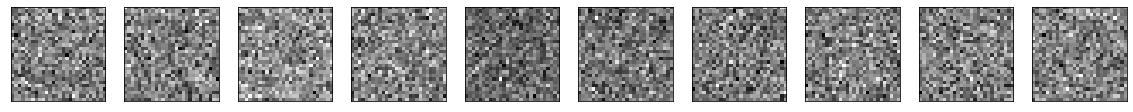

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(testNoise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

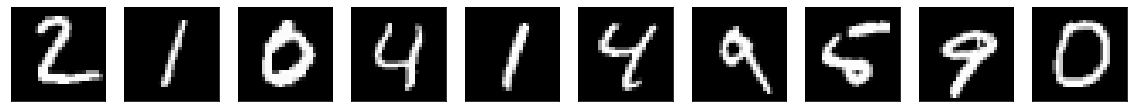

In [5]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(testX[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

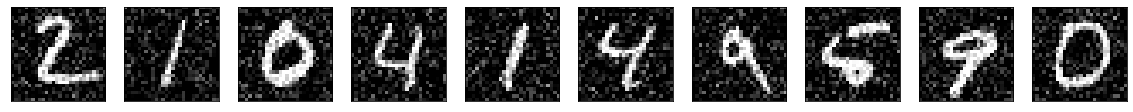

In [6]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(testXNoisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
#data augmentation
train_datagen = ImageDataGenerator(
 rotation_range=40,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True,
 fill_mode='nearest')

In [12]:
# Dense Block

def eamblock(input):

        body_1_1 = layers.Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')(input)

        body_1_2 = layers.Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')(body_1_1)

        body_2_1 = layers.Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')(input)

        body_2_2 = layers.Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')(body_2_1)

        concat_1_2 = Concatenate(axis=-1)([body_1_2,body_2_2])

        concat_1_2_conv = layers.Conv2D(64, (3,3),padding='same',activation='relu')(concat_1_2)

        add_1 = layers.Add()([concat_1_2_conv, input])

        body_3_1 = layers.Conv2D(64, (3,3),padding='same',activation='relu')(add_1)
        
        body_3_2 = layers.Conv2D(64, (3,3),padding='same')(body_3_1)

        add_2 = layers.Add()([body_3_2, add_1])

        add_2 = layers.Activation('relu')(add_2)

        body_4_1 = layers.Conv2D(64, (3,3),padding='same',activation='relu')(add_2)
        
        body_4_2 = layers.Conv2D(64, (3,3),padding='same',activation='relu')(body_4_1)

        body_4_3 = layers.Conv2D(64, (1,1),padding='same')(body_4_2)

        add_3 = layers.Add()([body_4_3, add_2])

        add_3 = layers.Activation('relu')(add_3)

        body_5_1 = layers.GlobalAveragePooling2D()(add_3)

        body_5_1 = tf.expand_dims(body_5_1,1)

        body_5_1 = tf.expand_dims(body_5_1,1)
                    
        body_5_2 = layers.Conv2D(4, (3,3),padding='same',activation='relu')(body_5_1)

        body_5_3 = layers.Conv2D(64, (3,3),padding='same',activation='sigmoid')(body_5_2)
        
        mult = layers.Multiply()([body_5_3, add_3])
        
        #add_4 = layers.Add()([mult, input])
        
        return mult

In [13]:
input = layers.Input(shape =(28, 28, 1))

feat_ext = layers.Conv2D(64, (3,3),padding='same')(input)

eam_block_1 = eamblock(feat_ext)

eam_block_2 = eamblock(eam_block_1)

eam_block_3 = eamblock(eam_block_2)

eam_block_4 = eamblock(eam_block_3)

#add_1 = layers.Add()([eam_block_4, feat_ext])

conv = layers.Conv2D(1, (3,3),padding='same')(eam_block_4)

add_2 = layers.Add()([conv, input])

In [14]:
model = Model(inputs=[input], outputs=[add_2])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 28, 28, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 28, 28, 64)   36928       conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 64)   36928       conv2d_13[0][0]                  
_______________________________________________________________________________________

In [15]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [16]:
batch_size = 64

In [17]:
# direct learning

model.fit(
 train_datagen.flow(trainXNoisy,trainX, batch_size=batch_size),
 validation_data = (testXNoisy, testX),
 epochs = 10)

Epoch 1/10
938/938 [==============================] - 161s 172ms/step - loss: 0.1282 - val_loss: 0.1052
Epoch 2/10
938/938 [==============================] - 163s 173ms/step - loss: 0.1024 - val_loss: 0.0907
Epoch 3/10
938/938 [==============================] - 162s 173ms/step - loss: 0.0935 - val_loss: 0.0889
Epoch 4/10
938/938 [==============================] - 162s 173ms/step - loss: 0.0890 - val_loss: 0.1069
Epoch 5/10
938/938 [==============================] - 162s 173ms/step - loss: 0.0858 - val_loss: 0.1007
Epoch 6/10
938/938 [==============================] - 162s 173ms/step - loss: 0.0825 - val_loss: 0.1090
Epoch 7/10
938/938 [==============================] - 162s 173ms/step - loss: 0.0792 - val_loss: 0.1184
Epoch 8/10
938/938 [==============================] - 162s 173ms/step - loss: 0.0753 - val_loss: 0.1218
Epoch 9/10
938/938 [==============================] - 161s 172ms/step - loss: 0.0725 - val_loss: 0.1083
Epoch 10/10
938/938 [==============================] - 161s 172m

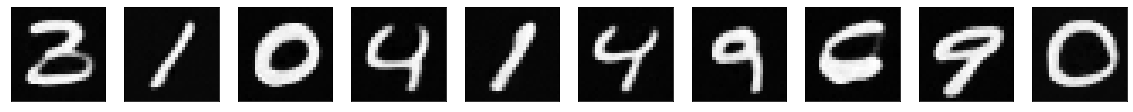

In [18]:
# direct learning

n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(model.predict(testXNoisy[i].reshape(1,28,28,1)).reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()